# Installation of required libraries and basic setup

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")
import os
import glob
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%cd /content/gdrive/MyDrive/Colab\ Notebooks
!ls



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks
 data				   model	 Unet.py
'Landslide4Sense solution.ipynb'   __pycache__	 utils.py


# Data Loading & Preprocessing

In [3]:

def load_dataset(image_paths, mask_paths=None):
    valid_images = []
    valid_masks = [] if mask_paths is not None else None
    corrupted_images_count = 0
    corrupted_masks_count = 0

    for i, img_path in enumerate(image_paths):
        try:
            with h5py.File(img_path, 'r') as hdf:
                data = np.array(hdf.get('img'), dtype=np.float32)
        except Exception as e:
            print(f"Skipping image file {img_path} due to error: {e}")
            corrupted_images_count += 1
            continue

        # Replace NaNs and compute mid values
        data[np.isnan(data)] = 1e-6
        mid_rgb       = data[:, :, 1:4].max() / 2.0
        mid_slope     = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # NDVI calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        ndvi = np.divide(data_nir - data_red, (data_nir + data_red) + 1e-6)

        # Build the 6‐channel image
        img_array = np.empty((128, 128, 6), dtype=np.float32)
        img_array[:, :, 0] = 1.0 - (data[:, :, 3] / (mid_rgb + 1e-6))     # R
        img_array[:, :, 1] = 1.0 - (data[:, :, 2] / (mid_rgb + 1e-6))     # G
        img_array[:, :, 2] = 1.0 - (data[:, :, 1] / (mid_rgb + 1e-6))     # B
        img_array[:, :, 3] = ndvi
        img_array[:, :, 4] = 1.0 - (data[:, :, 12] / (mid_slope + 1e-6))  # Slope
        img_array[:, :, 5] = 1.0 - (data[:, :, 13] / (mid_elevation + 1e-6))  # Elevation

        valid_images.append(img_array)

        if mask_paths is not None:
            try:
                with h5py.File(mask_paths[i], 'r') as hdf_mask:
                    mask_data = np.array(hdf_mask.get('mask'), dtype=np.float32)
                valid_masks.append(mask_data)
            except Exception as e:
                print(f"Skipping mask file {mask_paths[i]} due to error: {e}")
                corrupted_masks_count += 1
                continue

    X = np.array(valid_images)
    Y = np.array(valid_masks) if mask_paths is not None else None

    # Print summary
    print("Dataset loading completed:")
    print(f"Total image files provided: {len(image_paths)}")
    print(f"Valid images loaded: {X.shape[0]}")
    print(f"Corrupted/failed image files: {corrupted_images_count}")

    if mask_paths is not None:
        print(f"Total mask files provided: {len(mask_paths)}")
        print(f"Valid masks loaded: {Y.shape[0]}")
        print(f"Corrupted/failed mask files: {corrupted_masks_count}")

        # Count landslide‐positive vs. negative
        positive_count = sum(np.sum(mask) > 0 for mask in Y)
        negative_count = Y.shape[0] - positive_count
        print(f"Landslide positive images (mask > 0): {positive_count}")
        print(f"Non‐landslide images (mask sum == 0): {negative_count}")

    return X, Y


# Preparing Training and Validation

In [4]:
import glob, os
import matplotlib.pyplot as plt

os.chdir('/content/gdrive/MyDrive/Colab Notebooks/data')

TRAIN_PATH = sorted(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/data/TrainData/img/*.h5"))[:2600]
TRAIN_MASK = sorted(glob.glob("/content/gdrive/MyDrive/Colab Notebooks/data/TrainData/mask/*.h5"))[:2600]

# Loading training set...
TRAIN_XX, TRAIN_YY = load_dataset(TRAIN_PATH, TRAIN_MASK)

print("Train data shape:", TRAIN_XX.shape, TRAIN_YY.shape)
if TRAIN_XX.size > 0 and TRAIN_YY.size > 0:
    print("Train stats:", TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())
else:
    print("No data loaded. Check file paths and dataset.")

# Train/validation split
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(
    TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle=True
)

del TRAIN_XX, TRAIN_YY  # free memory if desired

# Expand mask dims
y_train = np.expand_dims(y_train, axis=-1)  # (80, 128, 128, 1)
y_valid = np.expand_dims(y_valid, axis=-1)  # (20, 128, 128, 1)




Skipping image file /content/gdrive/MyDrive/Colab Notebooks/data/TrainData/img/image_2789.h5 due to error: Unable to synchronously open file (file signature not found)
Dataset loading completed:
Total image files provided: 2600
Valid images loaded: 2599
Corrupted/failed image files: 1
Total mask files provided: 2600
Valid masks loaded: 2599
Corrupted/failed mask files: 0
Landslide positive images (mask > 0): 1589
Non‐landslide images (mask sum == 0): 1010
Train data shape: (2599, 128, 128, 6) (2599, 128, 128)
Train stats: -0.9999999 1.0 0.0 1.0


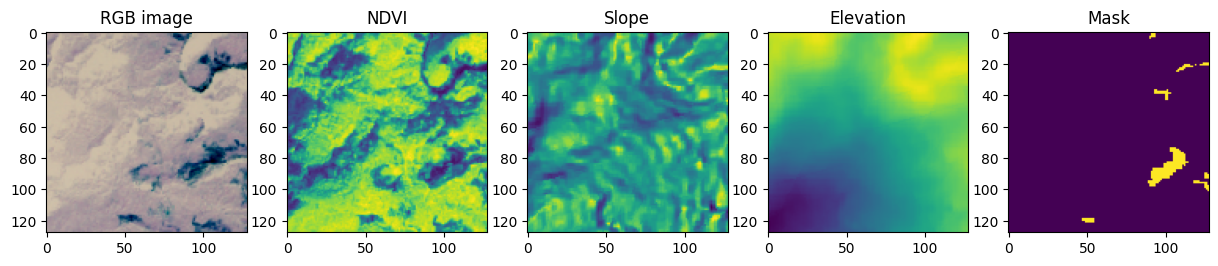

In [ ]:
# Quick visualization
sample_idx = 11
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 10))
ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask")

ax1.imshow(x_train[sample_idx, :, :, 0:3])
ax2.imshow(x_train[sample_idx, :, :, 3])
ax3.imshow(x_train[sample_idx, :, :, 4])
ax4.imshow(x_train[sample_idx, :, :, 5])
ax5.imshow(y_train[sample_idx, :, :, 0])
plt.show()

In [5]:
import tensorflow as tf

# Example: random horizontal & vertical flips
@tf.function
def random_flip(image, mask):
    # Flip left-right
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    # Flip up-down
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    return image, mask

# Create tf.data Datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(random_flip, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(16).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
valid_ds = valid_ds.batch(16).prefetch(tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras import backend as K

#  1) Loss & Metrics 
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f, y_pred_f = K.flatten(y_true), K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + (1.0 - dice_coefficient(y_true, y_pred))

def _unify_dims(y_true, y_pred):
    if y_true.shape.ndims == 3:
        y_true = tf.expand_dims(y_true, -1)
    return y_true, y_pred

def precision_m(y_true, y_pred):
    y_true, y_pred = _unify_dims(y_true, y_pred)
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    pp = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return tp / (pp + K.epsilon())

def recall_m(y_true, y_pred):
    y_true, y_pred = _unify_dims(y_true, y_pred)
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    return tp / (pos + K.epsilon())

def f1_m(y_true, y_pred):
    p, r = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    return 2 * (p * r) / (p + r + K.epsilon())


## Building and Compiling the UNET


In [ ]:
# Imports & Mixed Precision 
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Inflate ResNet50 to 6‑channel 
def get_inflated_resnet50(input_shape):
    h, w, c = input_shape
    temp = ResNet50(input_shape=(h, w, 3), include_top=False, weights='imagenet')
    first = temp.get_layer('conv1_conv')
    w3, b3 = first.get_weights()
    w6 = np.concatenate([w3, w3], axis=2) / 2.0
    backbone = ResNet50(input_shape=(h, w, 6), include_top=False, weights=None)
    new_first = backbone.get_layer('conv1_conv')
    new_first.set_weights([w6, b3])
    return backbone

# 3) CBAM 
def cbam_block(x, ratio=8):
    ch = x.shape[-1]
    avg = layers.GlobalAveragePooling2D()(x)
    max_ = layers.GlobalMaxPooling2D()(x)
    avg = layers.Reshape((1,1,ch))(avg); max_ = layers.Reshape((1,1,ch))(max_)
    d1 = layers.Dense(ch//ratio, activation='relu', kernel_initializer='he_normal')
    d2 = layers.Dense(ch, kernel_initializer='he_normal')
    a1, a2 = d2(d1(avg)), d2(d1(max_))
    attn = layers.Activation('sigmoid')(layers.Add()([a1, a2]))
    x = layers.multiply([x, attn])
    avg_sp = layers.Lambda(lambda t: K.mean(t, axis=-1, keepdims=True))(x)
    max_sp = layers.Lambda(lambda t: K.max(t, axis=-1, keepdims=True))(x)
    sp = layers.Concatenate(axis=-1)([avg_sp, max_sp])
    sp = layers.Conv2D(1,7,padding='same',activation='sigmoid',kernel_initializer='he_normal')(sp)
    return layers.multiply([x, sp])

#  4) ASPP with BatchNorm+SpatialDropout 
def aspp_module(x, filters=128, rates=(6,12,18), dropout=0.2):
    dims = K.int_shape(x)
    pool = layers.GlobalAveragePooling2D()(x)
    pool = layers.Reshape((1,1,dims[-1]))(pool)
    pool = layers.Conv2D(filters,1,activation='relu',kernel_initializer='he_normal',padding='same')(pool)
    pool = layers.UpSampling2D((dims[1],dims[2]),interpolation='bilinear')(pool)
    branches = [pool, layers.Conv2D(filters,1,activation='relu',kernel_initializer='he_normal',padding='same')(x)]
    for r in rates:
        branches.append(layers.Conv2D(filters,3,dilation_rate=r,activation='relu',kernel_initializer='he_normal',padding='same')(x))
    y = layers.Concatenate()(branches)
    y = layers.Conv2D(filters,1,activation='relu',kernel_initializer='he_normal',padding='same')(y)
    y = layers.BatchNormalization()(y)
    return layers.SpatialDropout2D(dropout)(y)

#  5) Build ResU‑Net + ASPP + CBAM 
def build_resunet_aspp_cbam(h, w, c):
    inp = layers.Input((h, w, c))
    backbone = get_inflated_resnet50((h, w, c))
    skip_names = ['conv1_relu','conv2_block3_out','conv3_block4_out','conv4_block6_out']
    skips = [backbone.get_layer(n).output for n in skip_names]
    enc_model = Model(backbone.input, skips + [backbone.output], name="ResNet50_Enc")
    s1, s2, s3, s4, bot = enc_model(inp)
    # bottleneck
    x = aspp_module(bot)
    x = cbam_block(x)
    # decoder
    def up_block(x, skip, f):
        x = layers.Conv2DTranspose(f,2,strides=2,padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(f,3,activation='relu',padding='same',kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        return layers.SpatialDropout2D(0.1)(x)
    x = up_block(x, s4, 128)
    x = up_block(x, s3,  64)
    x = up_block(x, s2,  32)
    x = up_block(x, s1,  16)
    x = layers.Conv2DTranspose(16,2,strides=2,padding='same')(x)
    out = layers.Conv2D(1,1,activation='sigmoid',dtype='float32')(x)
    return Model(inp, out, name="ResUNet_ASPP_CBAM")

#  6) Callbacks 
callbacks = [
    ModelCheckpoint("/content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras",
                    monitor="val_f1_m", mode="max", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_f1_m", mode="max", patience=10,
                  restore_best_weights=True, verbose=1),
]

#  7) Two‑Phase Training 
tf.keras.backend.clear_session()
model = build_resunet_aspp_cbam(128,128,6)

# Phase 1: freeze encoder
for layer in model.layers:
    if layer.name.startswith("resnet"):
        layer.trainable = False

model.compile(Adam(1e-4), loss=bce_dice_loss, metrics=[f1_m, precision_m, recall_m])
history1 = model.fit(train_ds, validation_data=valid_ds,
                     epochs=20, callbacks=callbacks, verbose=2)

# Phase 2: unfreeze & fine‑tune @ lower LR
for layer in model.layers:
    if layer.name.startswith("resnet"):
        layer.trainable = True

model.compile(Adam(1e-5), loss=bce_dice_loss, metrics=[f1_m, precision_m, recall_m])
history2 = model.fit(train_ds, validation_data=valid_ds,
                     epochs=30,
                     callbacks=callbacks + [ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)],
                     verbose=2)


/usr/local/lib/python3.11/dist-packages/keras/src/applications/resnet.py:127: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 6 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Epoch 1/20

Epoch 1: val_f1_m improved from -inf to 0.39532, saving model to /content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras
130/130 - 185s - 1s/step - f1_m: 0.1158 - loss: 1.6063 - precision_m: 0.0629 - recall_m: 0.9280 - val_f1_m: 0.3953 - val_loss: 1.4879 - val_precision_m: 0.2788 - val_recall_m: 0.7326
Epoch 2/20

Epoch 2: val_f1_m improved from 0.39532 to 0.48873, saving model to /content/gdrive/MyDrive/Colab Notebooks/model/best_model.keras
130/130 - 32s - 248ms/step - f1_m: 0.2203 - loss: 1.5281 - precision_m: 0.1296 - recall_m: 0.9448 - val_f1_m: 0.4887 - val_loss: 1.4074 - val_precision_m: 0.3541 - val_recall_m: 0.8299
Epoch 3/20

Epoch 3: val_f1_m did not improve from 0.48873
130/130 - 36s - 279ms/step - f1_m: 0.3628 - loss: 1.4533 - precision_m: 0.2379 - recall_m: 0.9133 - val_f1_m: 0.4121 - val_loss: 1.3853 - val_precision_m: 0.2671 - val_recall_m: 0.9373
Epoch 4/20

Epoch 4: val_f1_m improved from 0.48873 to 0.52132, saving model to /content/gdrive/MyDrive/C

## Training with Callbacks


## Evaluate

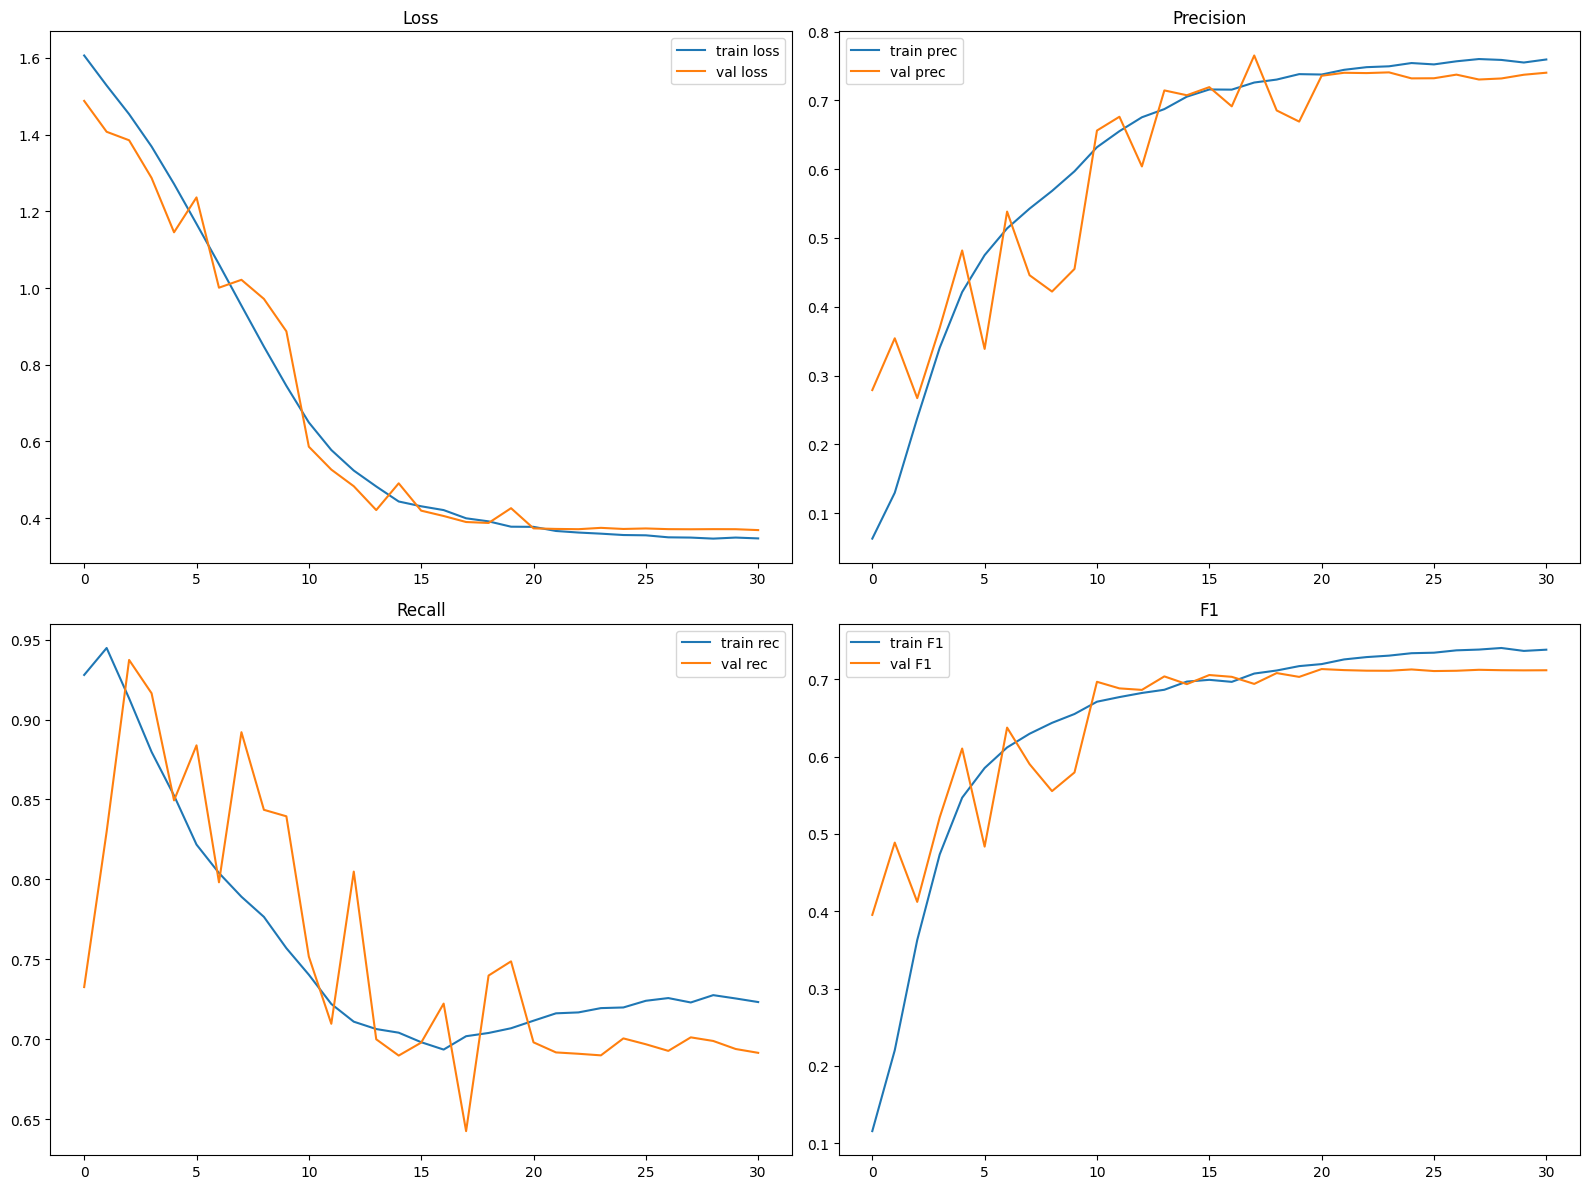

In [8]:
# build a single dict by concatenation
combined = {}
for key in history1.history:
    combined[key] = history1.history[key] + history2.history.get(key, [])

# now plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,12))

# loss
ax1.plot(combined['loss'],    label='train loss')
ax1.plot(combined['val_loss'],label='val loss')
ax1.set_title('Loss'); ax1.legend()

# precision
ax2.plot(combined['precision_m'],    label='train prec')
ax2.plot(combined['val_precision_m'],label='val prec')
ax2.set_title('Precision'); ax2.legend()

# recall
ax3.plot(combined['recall_m'],    label='train rec')
ax3.plot(combined['val_recall_m'],label='val rec')
ax3.set_title('Recall'); ax3.legend()

# F1
ax4.plot(combined['f1_m'],    label='train F1')
ax4.plot(combined['val_f1_m'],label='val F1')
ax4.set_title('F1'); ax4.legend()

plt.tight_layout()
plt.show()


## Prediction Example

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step


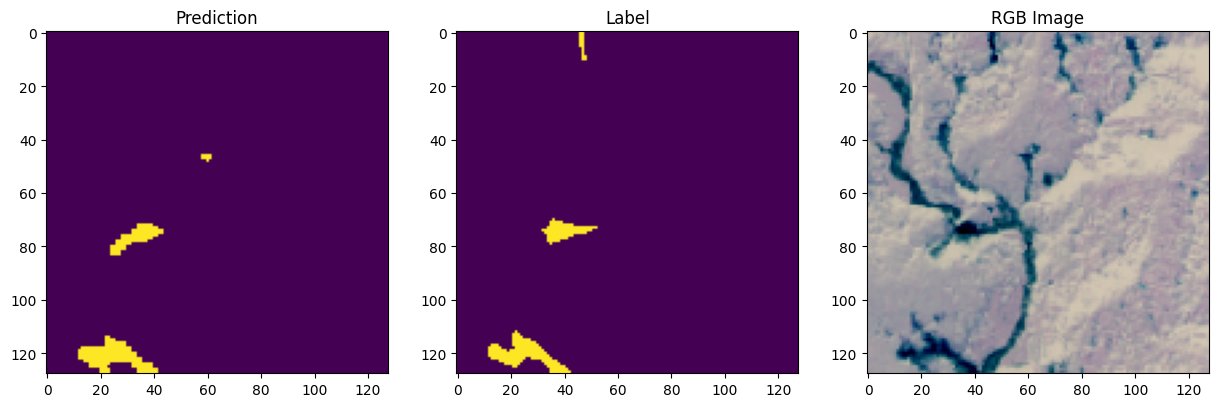

In [12]:
threshold = 0.5
pred_img = model.predict(x_valid)  # shape: (num_samples, 128, 128, 1)
pred_img = (pred_img > threshold).astype(np.uint8)

img_idx = 21
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
ax1.imshow(pred_img[img_idx, :, :, 0])
ax1.set_title("Prediction")
ax2.imshow(y_valid[img_idx, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img_idx, :, :, 0:3])
ax3.set_title("RGB Image")
plt.show()


## Validating on New Data

Dataset loading completed:
Total image files provided: 245
Valid images loaded: 245
Corrupted/failed image files: 0
Validation images shape: (245, 128, 128, 6)
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


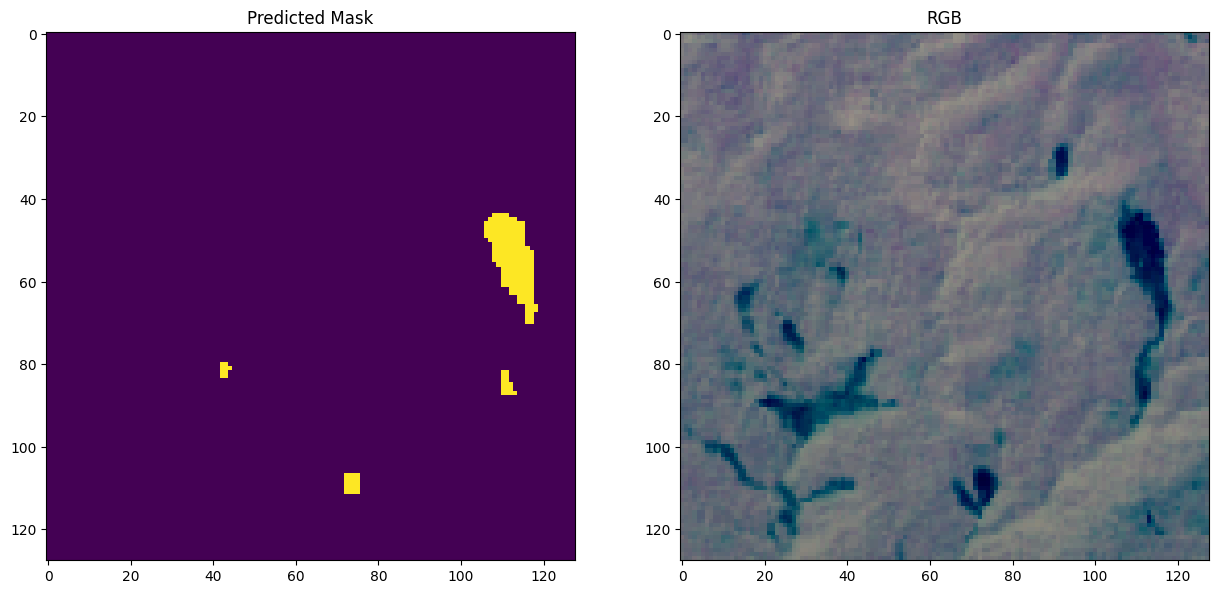

In [17]:
validation_url = "/content/gdrive/MyDrive/Colab Notebooks/data/ValidateData/*.h5"
img_val_paths = sorted(glob.glob(validation_url))

VAL_XX, _ = load_dataset(img_val_paths, mask_paths=None)
print("Validation images shape:", VAL_XX.shape)

val_preds = model.predict(VAL_XX)
val_preds = (val_preds > threshold).astype(np.uint8)

img_val_idx = 1
fig, (axv1, axv2) = plt.subplots(1, 2, figsize=(15, 10))
axv1.imshow(val_preds[img_val_idx, :, :, 0])
axv1.set_title("Predicted Mask")
axv2.imshow(VAL_XX[img_val_idx, :, :, 0:3])
axv2.set_title("RGB")
plt.show()

# Optionally save predicted masks
write_directory = "data/validation/mask"
os.makedirs(write_directory, exist_ok=True)
for i, img_path in enumerate(img_val_paths):
    name = os.path.basename(img_path).replace("image", "mask")
    with h5py.File(os.path.join(write_directory, name), 'w') as h5f:
        pred_mask = val_preds[i, :, :, 0]
        h5f.create_dataset('mask', data=pred_mask)


## Interpretability: Saliency Map & Grad-CAM

Dataset loading completed:
Total image files provided: 245
Valid images loaded: 245
Corrupted/failed image files: 0
Validation images shape: (245, 128, 128, 6)
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


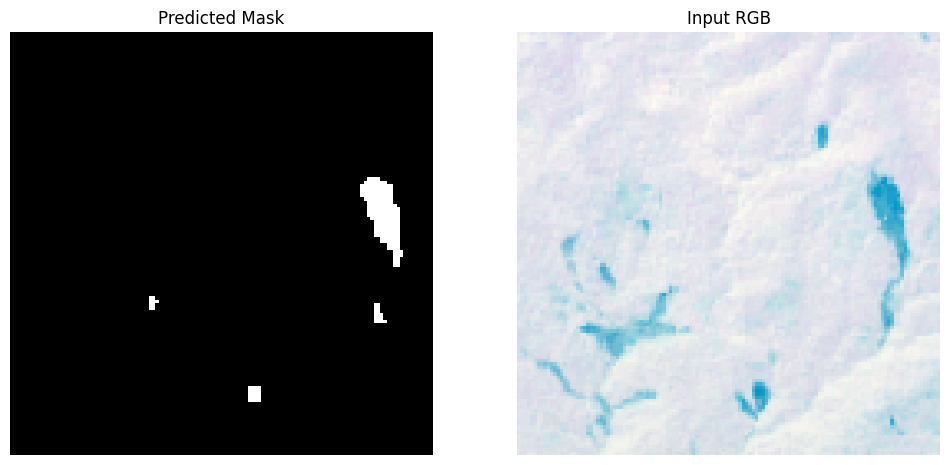

Channel sensitivities (zero baseline):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
  ch 0: 0.0151
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
  ch 1: 0.0045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
  ch 2: 0.0070
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
  ch 3: 0.0153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
  ch 4: 0.0061
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
  ch 5: 0.0052


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 6))
  warnings.warn(msg)


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━

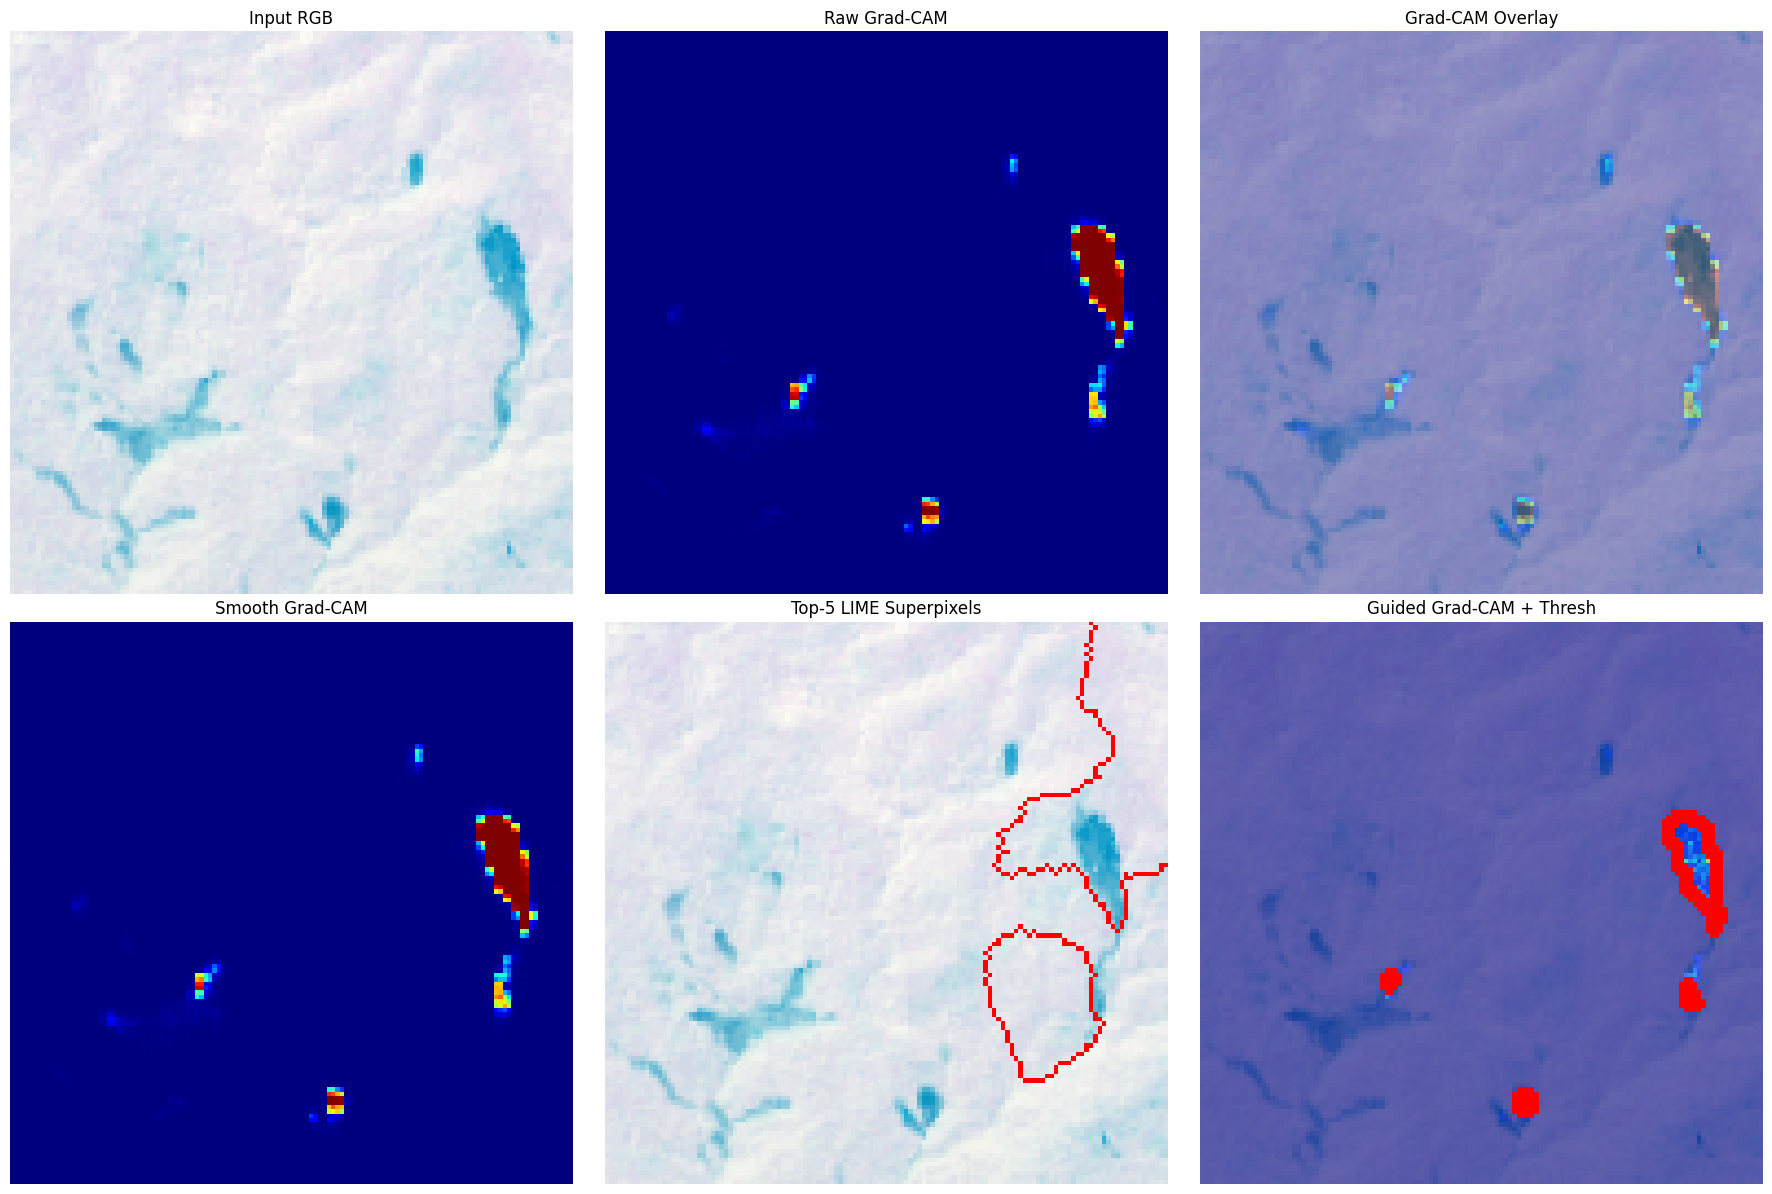

In [ ]:
#  Imports & Functions 
import os
import glob
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from lime import lime_image
from skimage.segmentation import slic, mark_boundaries


def channel_sensitivity(model, x, channel_idx, baseline='zero'):
    orig = model.predict(x)[0, ..., 0]
    x_mod = x.copy()
    if baseline == 'zero':
        x_mod[0, ..., channel_idx] = 0.0
    else:
        x_mod[0, ..., channel_idx] = x_mod[0, ..., channel_idx].mean()
    new = model.predict(x_mod)[0, ..., 0]
    return float(np.mean(np.abs(orig - new)))

def compute_gradcam(model, img, layer_name=None):
    x = img[None]
    if layer_name is None:
        layer_name = next(l.name for l in reversed(model.layers) if 'conv2d' in l.name)
    grad_model = Model(model.inputs,
                       [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        fmap, pred = grad_model(x)
        loss = tf.reduce_sum(pred)
    grads   = tape.gradient(loss, fmap)[0]                # (h',w',c)
    weights = tf.reduce_mean(grads, axis=(0,1))           # (c,)
    cam     = tf.reduce_sum(fmap[0] * weights, axis=-1)   # (h',w')
    cam     = tf.nn.relu(cam)
    cam     = cam / (tf.reduce_max(cam) + 1e-8)
    cam     = cam.numpy()
    return cv2.resize(cam, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)

def compute_smooth_gradcam(model, img, nsamples=8, noise_level=0.1, layer_name=None):
    h, w = img.shape[:2]
    cams = np.zeros((h, w), np.float32)
    std = img.std()
    for _ in range(nsamples):
        noise = np.random.normal(0, noise_level * std, img.shape).astype(np.float32)
        cams += compute_gradcam(model, img + noise, layer_name)
    cams = cams / nsamples
    cams = (cams - cams.min()) / (cams.max() - cams.min() + 1e-8)
    return cams

def compute_lime_overlay(model, img, top_k=5, num_samples=500):
    rgb = img[..., :3]
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)

    def predict_rgb_batch(rgb_list):
        batch = []
        for im3 in rgb_list:
            im6 = np.concatenate([im3, img[..., 3:]], axis=-1)
            batch.append(im6)
        batch = np.stack(batch, 0).astype(np.float32)
        preds = model.predict(batch)  # (N,H,W,1)
        return preds.reshape((preds.shape[0], -1))

    explainer = lime_image.LimeImageExplainer()
    seg_fn    = lambda x: slic(x, n_segments=50, compactness=10)
    exp = explainer.explain_instance(
        rgb_norm.astype('double'),
        predict_rgb_batch,
        top_labels=1, hide_color=0,
        num_samples=num_samples,
        segmentation_fn=seg_fn
    )
    label       = exp.top_labels[0]
    seg_weights = dict(exp.local_exp[label])
    segments    = seg_fn((rgb_norm * 255).astype(np.uint8))
    top_segs    = sorted(seg_weights, key=lambda s: seg_weights[s], reverse=True)[:top_k]
    mask        = np.isin(segments, top_segs)
    overlay     = mark_boundaries(rgb_norm, mask, color=(1,0,0))
    return overlay, rgb_norm

def overlay_heatmap(rgb, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    hm8      = np.uint8(255 * heatmap)
    hm_color = cv2.applyColorMap(hm8, colormap)[:, :, ::-1] / 255.0
    return (1 - alpha) * rgb + alpha * hm_color

#  1) Load & Predict on Validation Set 
validation_url = "/content/gdrive/MyDrive/Colab Notebooks/data/ValidateData/*.h5"
img_val_paths  = sorted(glob.glob(validation_url))
VAL_XX, _      = load_dataset(img_val_paths, mask_paths=None)
print("Validation images shape:", VAL_XX.shape)

threshold = 0.5
val_preds = model.predict(VAL_XX)
val_preds = (val_preds > threshold).astype(np.uint8)

# pick the same index you used before
img_val_idx = 1
img         = VAL_XX[img_val_idx]            # (128,128,6)
mask_pred   = val_preds[img_val_idx, :, :, 0] # (128,128)
mask_bin    = mask_pred.astype(np.uint8)

#  2) Plot Predicted Mask vs. RGB 
rgb = img[..., :3]
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)

fig, (axm, axr) = plt.subplots(1, 2, figsize=(12, 6))
axm.imshow(mask_pred, cmap='gray')
axm.set_title("Predicted Mask")
axm.axis('off')
axr.imshow(rgb)
axr.set_title("Input RGB")
axr.axis('off')
plt.show()

#  3) Channel Sensitivity 
print("Channel sensitivities (zero baseline):")
for c in range(img.shape[-1]):
    print(f"  ch {c}: {channel_sensitivity(model, img[None], c):.4f}")

#  4) Compute Interpretability Maps 
plain_cam  = compute_gradcam(model, img)
smooth_cam = compute_smooth_gradcam(model, img, nsamples=12, noise_level=0.05)
lime_ov, _ = compute_lime_overlay(model, img, top_k=5, num_samples=500)

# guided saliency
with tf.GradientTape() as tape:
    inp  = tf.cast(img[None], tf.float32)
    tape.watch(inp)
    pred = model(inp)[0, ..., 0]
    loss = tf.reduce_sum(pred)
grads   = tape.gradient(loss, inp)[0].numpy()       # (128,128,6)
sal_map = np.max(np.abs(grads), axis=-1)            # (128,128)
sal_map = (sal_map - sal_map.min())/(sal_map.max()-sal_map.min()+1e-8)
guided_cam = plain_cam * sal_map
thr       = np.percentile(guided_cam, 75)
th_cam    = np.where(guided_cam >= thr, guided_cam, 0)
ov_guided = overlay_heatmap(rgb, th_cam, alpha=0.6)
cnts,_   = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ovg      = (ov_guided * 255).astype(np.uint8)
cv2.drawContours(ovg, cnts, -1, (255,0,0), 2)
ov_guided = ovg.astype(np.float32) / 255.0

#  5) Plot Interpretability Grid 
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

axs[0,0].imshow(rgb)
axs[0,0].set_title("Input RGB")
axs[0,0].axis("off")

axs[0,1].imshow(plain_cam, cmap="jet")
axs[0,1].set_title("Raw Grad‑CAM")
axs[0,1].axis("off")

axs[0,2].imshow(overlay_heatmap(rgb, plain_cam, alpha=0.4))
axs[0,2].set_title("Grad‑CAM Overlay")
axs[0,2].axis("off")

axs[1,0].imshow(smooth_cam, cmap="jet")
axs[1,0].set_title("Smooth Grad‑CAM")
axs[1,0].axis("off")

axs[1,1].imshow(lime_ov)
axs[1,1].set_title("Top‑5 LIME Superpixels")
axs[1,1].axis("off")

axs[1,2].imshow(ov_guided)
axs[1,2].set_title("Guided Grad‑CAM + Thresh")
axs[1,2].axis("off")

plt.tight_layout()
plt.show()


# Sensitivity Analysis


In [ ]:
def channel_sensitivity(model, x, channel_idx, baseline='zero'):
    original_pred = model.predict(x)[0, :, :, 0]

    x_mod = x.copy()
    if baseline == 'zero':
        x_mod[0, :, :, channel_idx] = 0.0
    else:
        # set channel to mean value
        mean_val = np.mean(x_mod[0, :, :, channel_idx])
        x_mod[0, :, :, channel_idx] = mean_val

    new_pred = model.predict(x_mod)[0, :, :, 0]
    diff = np.abs(original_pred - new_pred)
    mean_diff = diff.mean()
    return mean_diff

# Example usage: measure each channel’s importance
test_img = x_valid[None, 0, ...]  # pick one image
num_channels = test_img.shape[-1]
for c in range(num_channels):
    sensitivity = channel_sensitivity(model, test_img, c, baseline='zero')
    print(f"Channel {c} sensitivity (zero baseline):", sensitivity)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Channel 0 sensitivity (zero baseline): 0.13150474
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Channel 1 sensitivity (zero baseline): 0.058811966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Channel 2 sensitivity (zero baseline): 0.044299066
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Channel 3 sensitivity (zero baseline): 0.07630831
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Channel 4 sensitivity (zero baseline): 0.13128477
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Channel 5 sensitivity (zero baseline): 0.0057323216


## Implementing LIME